# The third part of makemore


This is from a [video](https://www.youtube.com/watch?v=P6sfmUTpUmc) from Andrej Karpathy. Working on [makemore](https://github.com/karpathy/makemore) repo


## Paper material:
- RNN, paper [Mikolov et al. 2010](https://www.fit.vutbr.cz/research/groups/speech/publi/2010/mikolov_interspeech2010_IS100722.pdf)
- LSTM, paper [Graves et al. 2014](https://arxiv.org/abs/1308.0850)
- GRU, paper [Kyunghyun Cho et al. 2014](https://arxiv.org/abs/1409.1259)


## Other paper material:

Kaiming init topic:
- Delving Deep into Rectifiers:
  - [Surpassing Human-Level Performance on ImageNet Classification](https://arxiv.org/pdf/1502.01852)
 
Batch Normalization: 
- Accelerating Deep Network Training by
  - [Reducing Internal Covariate Shift](https://arxiv.org/pdf/1502.03167)




In [1]:
print("hello world")

hello world


In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%env KMP_DUPLICATE_LIB_OK=TRUE
%matplotlib inline

env: KMP_DUPLICATE_LIB_OK=TRUE


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [7]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [121]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True


12097


In [86]:
(torch.randn(1000) * 0.2).std()

tensor(0.2014)

In [88]:
(5/3) / ((n_embd * block_size) ** 0.5)

0.3042903097250923

tensor(-0.0002) tensor(1.0048)
tensor(0.0035) tensor(1.0222)


(array([2.17416366e-05, 0.00000000e+00, 0.00000000e+00, 1.95674729e-04,
        1.08708183e-04, 8.69665464e-05, 2.82641276e-04, 5.43540915e-04,
        9.13148737e-04, 2.10893875e-03, 3.02208749e-03, 5.41366751e-03,
        7.67479772e-03, 1.26753741e-02, 2.05675882e-02, 3.18949809e-02,
        4.72228347e-02, 7.11603766e-02, 1.01424735e-01, 1.43125194e-01,
        1.93000508e-01, 2.57725360e-01, 3.15971205e-01, 3.71434120e-01,
        4.08199227e-01, 4.20091902e-01, 4.04350957e-01, 3.63694097e-01,
        3.06122243e-01, 2.39418902e-01, 1.87217233e-01, 1.38124617e-01,
        9.95766956e-02, 6.97906535e-02, 4.44833885e-02, 2.92642429e-02,
        1.94152815e-02, 1.26971158e-02, 7.82698918e-03, 4.39181059e-03,
        2.84815439e-03, 1.76107256e-03, 1.04359856e-03, 5.00057642e-04,
        4.13091095e-04, 2.17416366e-04, 1.73933093e-04, 0.00000000e+00,
        4.34832732e-05, 8.69665464e-05]),
 array([-5.84577227, -5.61579878, -5.38582529, -5.1558518 , -4.92587831,
        -4.69590483, 

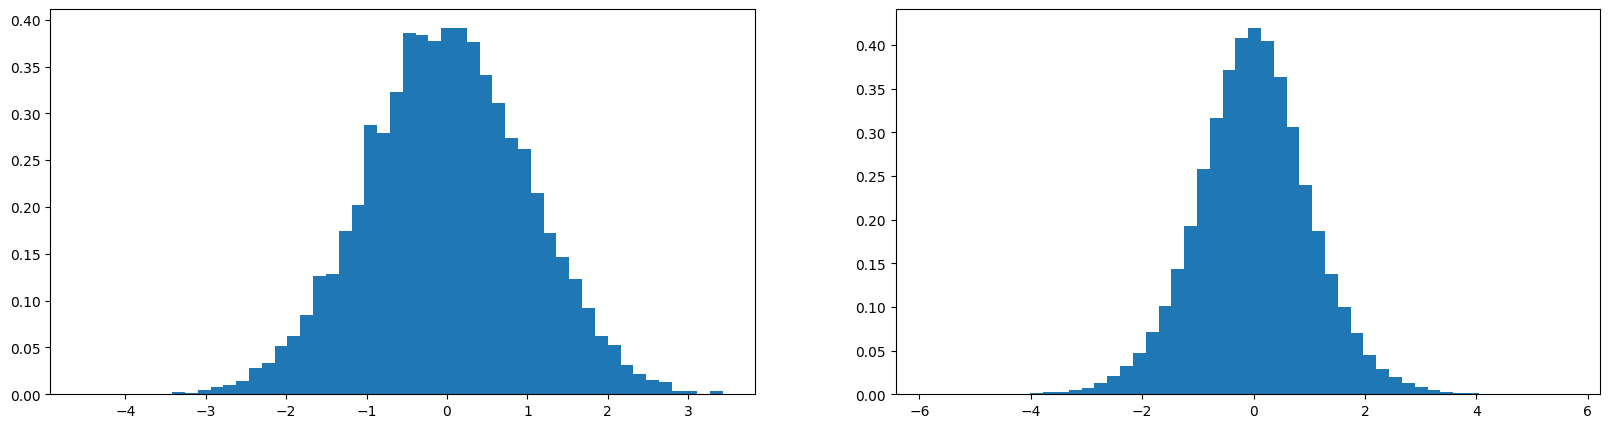

In [85]:
x = torch.randn(1000,10)
w = torch.randn(10, 200) / 10**0.5 # to achieve 1 std - divide by inputs(10) square root(10**0.5)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

In [93]:
hpreact.shape

torch.Size([32, 200])

In [95]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [96]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

In [122]:
# running training
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X and Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    


      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6413
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


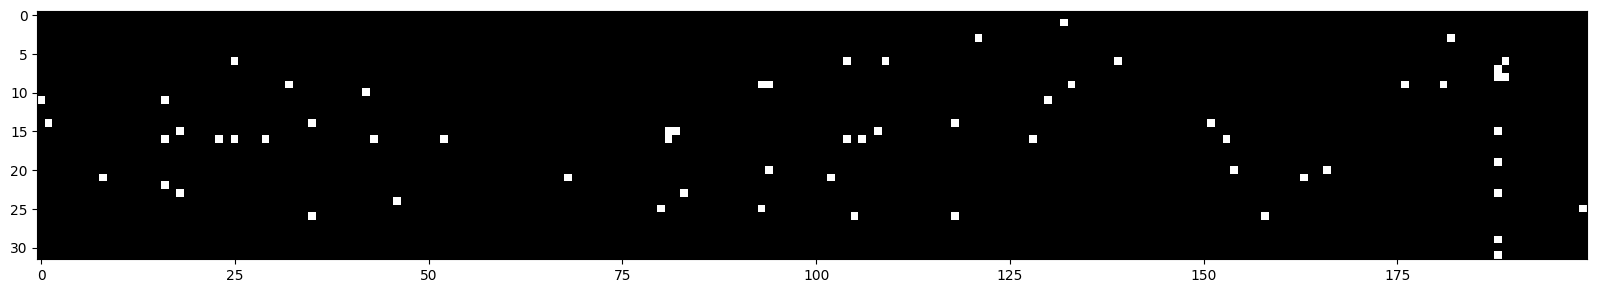

In [75]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [37]:
# initial loss should be - log 1/27 = -3.2958
ex = torch.tensor([1/27])
- ex.log()

tensor([3.2958])

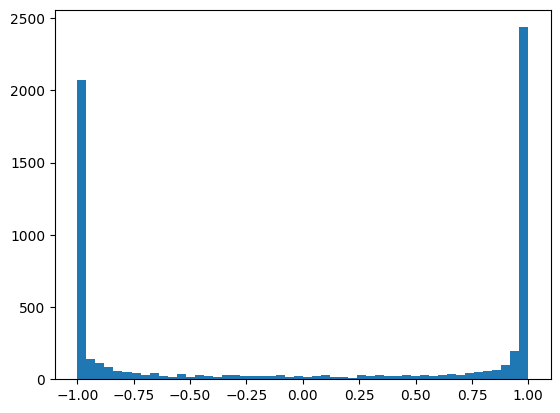

In [63]:
plt.hist(h.view(-1).tolist(), 50);

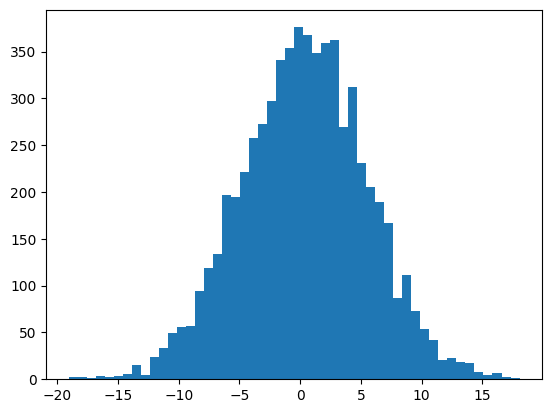

In [64]:
plt.hist(hpreact.view(-1).tolist(), 50);

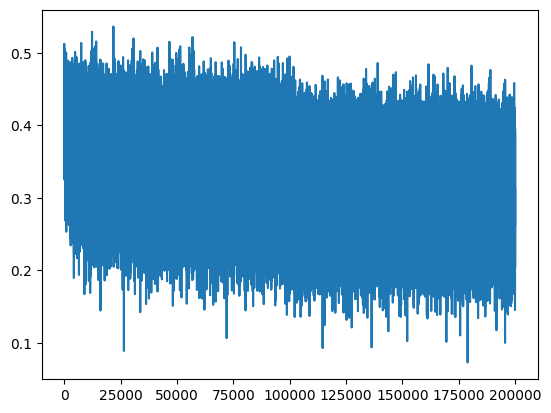

In [44]:
plt.plot(lossi)

In [22]:
# 4 dimensional example of the issue
# initial loss can be high with disperse numbers
logits = torch.tensor([-133.0, 25.0, 0.0, 22.0])

probs = torch.softmax(logits, dim=0)

loss = -probs[2].log()
logits, probs, loss



(tensor([-133.,   25.,    0.,   22.]),
 tensor([0.0000e+00, 9.5257e-01, 1.3229e-11, 4.7426e-02]),
 tensor(25.0486))

In [ ]:
# loss log

# original
train 2.12
val   2.16

# fix softmax confidently wrong:
train 2.07
val   2.13

# fix tanh layer too saturated at init:
train 2.035708427429199
val 2.1029491424560547

# W1 initialization using gain and fan-in (instead of magic numbers)
train 2.0376644134521484
val 2.106989622116089

# using abtch normalization
train 2.066880226135254
val 2.1049394607543945

In [109]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1 # hiddent layer pre-activation
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

# forward pass
    emb = C[Xb] # (32, 3, 10)
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1 # hiddent layer pre-activation
    hpreact = hpreact - hpreact.mean(0, keepdim=True) / hpreact.std(0, keepdim=True)

split_loss('train')
split_loss('val')

train 2.066880226135254
val 2.1049394607543945


In [47]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with dots
    while True:
      emb = C[torch.tensor([context])]  # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

montaymyah.
seel.
nihahalee.
thastendraegen.
ched.
eliah.
milopileigh.
estanaraelyzion.
karin.
shubergehiraest.
jair.
jeniquethalayzon.
ged.
ryyah.
fael.
yuva.
myson.
amahia.
aalynn.
julian.


# 

# SUMMARY + PYTORCHIFYING -----------

In [165]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True # can work differently if not in training
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad(): # not needed since no backward() will be used for running_mean, running_var
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3 #0.5 #5/3 # 3.0 #  # 1.0

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47551


In [172]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])









      0/ 200000: 2.6653
  10000/ 200000: 2.0877
  20000/ 200000: 2.2555
  30000/ 200000: 1.9161
  40000/ 200000: 2.0609
  50000/ 200000: 2.0670
  60000/ 200000: 1.7508
  70000/ 200000: 1.9363
  80000/ 200000: 2.2114
  90000/ 200000: 1.7585
 100000/ 200000: 1.8040
 110000/ 200000: 1.7610
 120000/ 200000: 1.6224
 130000/ 200000: 1.7439
 140000/ 200000: 1.8426
 150000/ 200000: 2.0708
 160000/ 200000: 2.0895
 170000/ 200000: 2.0060
 180000/ 200000: 1.8875
 190000/ 200000: 1.6741


# Useful statistics to review our model

layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.47%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.16%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.78%


Text(0.5, 1.0, 'activation distribution')

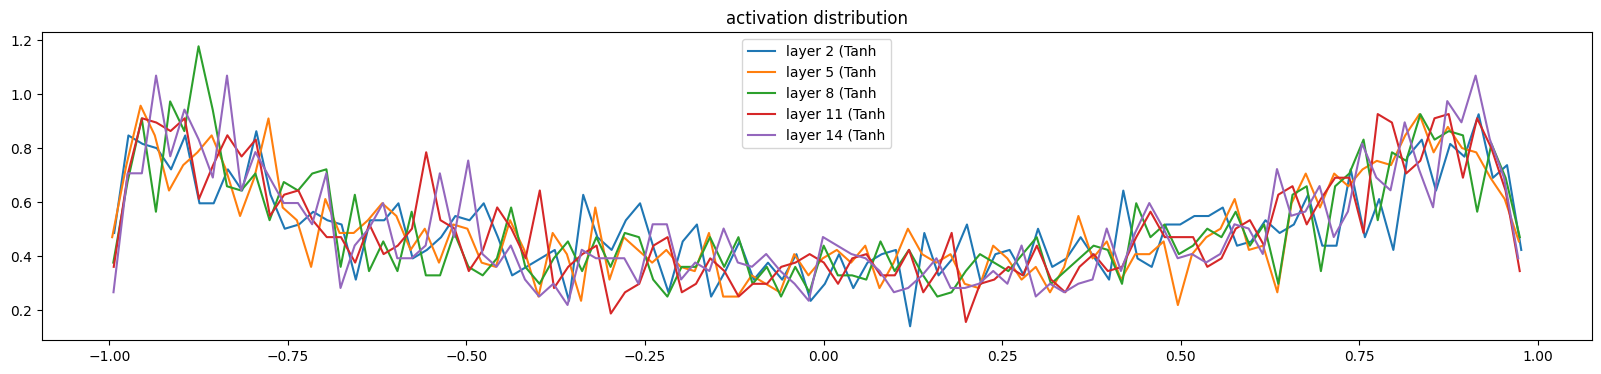

In [167]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 3.682951e-03
layer 5 (      Tanh): mean +0.000000, std 3.262607e-03
layer 8 (      Tanh): mean +0.000000, std 2.973728e-03
layer 11 (      Tanh): mean -0.000000, std 2.741109e-03
layer 14 (      Tanh): mean +0.000000, std 2.584293e-03


Text(0.5, 1.0, 'gradient distribution')

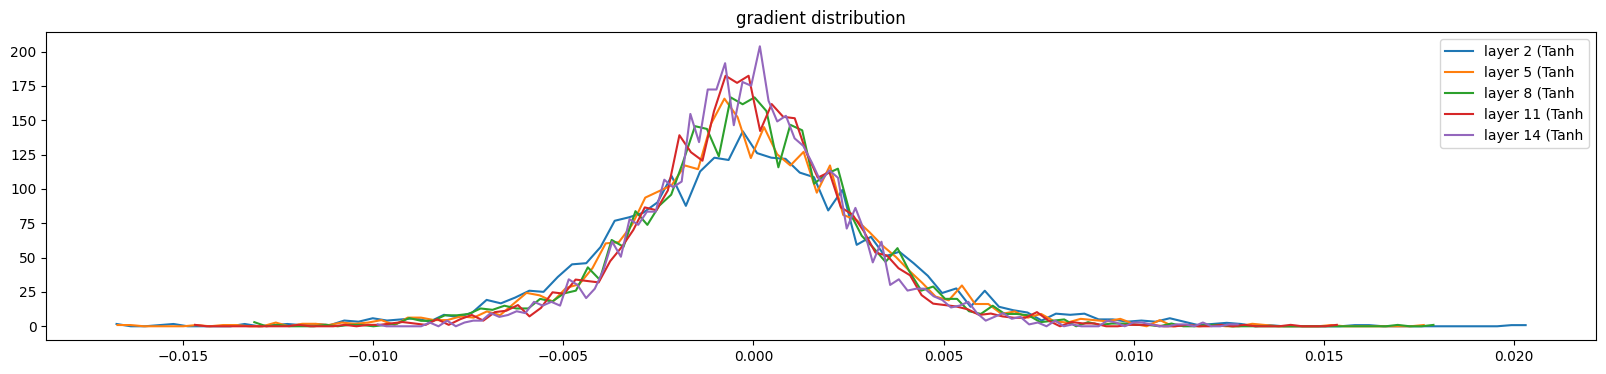

In [168]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad # taking the gradient instead
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 1.019884e-02 | grad:data ratio 1.018845e-02
weight  (30, 100) | mean +0.000092 | std 8.238422e-03 | grad:data ratio 2.635836e-02
weight (100, 100) | mean +0.000031 | std 7.318106e-03 | grad:data ratio 4.377140e-02
weight (100, 100) | mean -0.000019 | std 6.662022e-03 | grad:data ratio 3.949895e-02
weight (100, 100) | mean -0.000019 | std 5.821513e-03 | grad:data ratio 3.468159e-02
weight (100, 100) | mean +0.000053 | std 5.445294e-03 | grad:data ratio 3.243366e-02
weight  (100, 27) | mean -0.000165 | std 1.046844e-02 | grad:data ratio 6.281262e-02


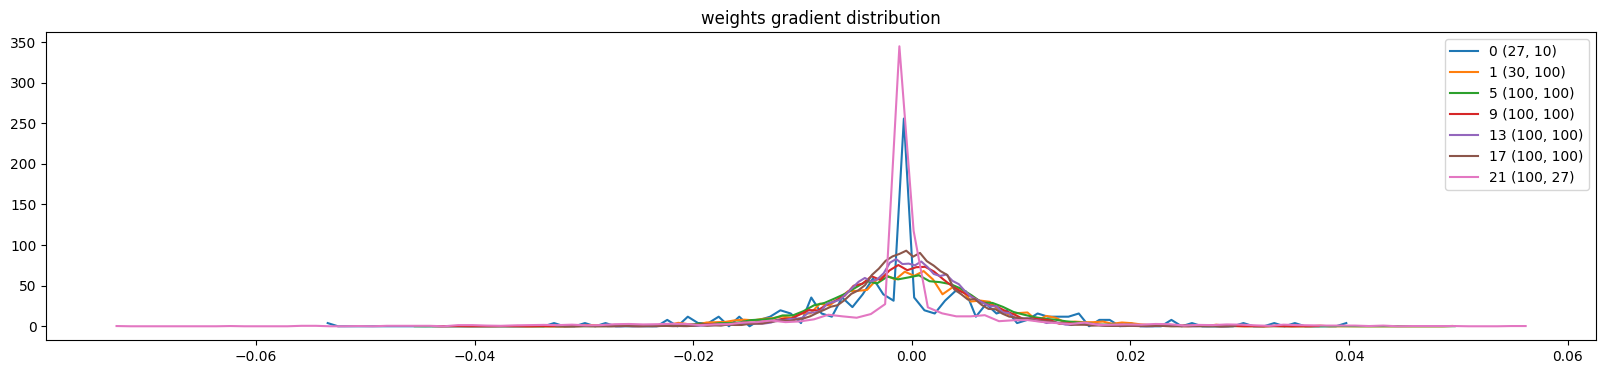

In [169]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

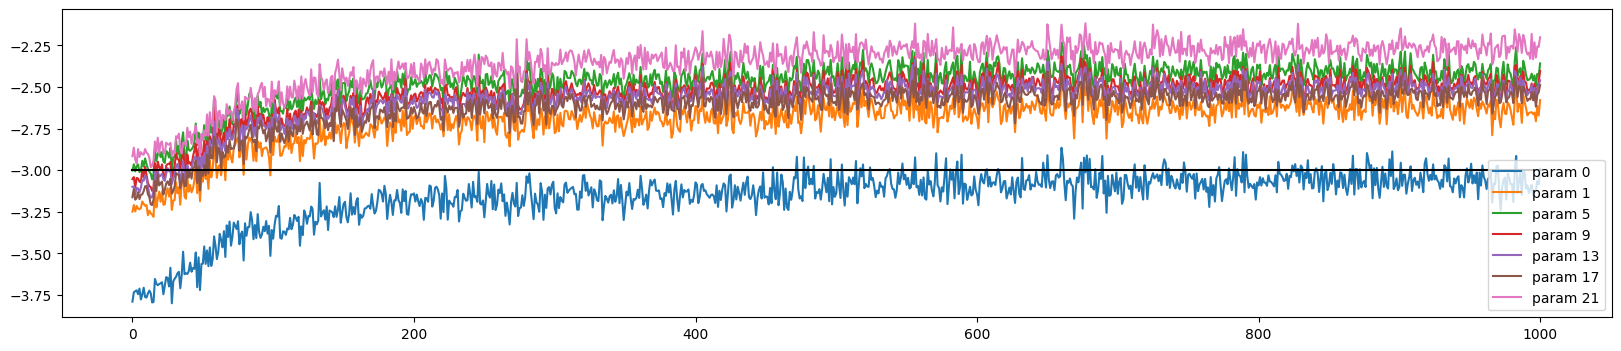

In [170]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

# Validate the new model

In [171]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.434417963027954
val 2.4324371814727783


In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word